## Вариант 1

In [6]:
sales_train = pd.read_csv('sales_train.csv')
items_data = pd.read_csv('items.csv')
item_categories_data = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [7]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sales_train['date'] = pd.to_datetime(sales_train['date'], dayfirst=True)
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year


sales_train = sales_train[sales_train['item_cnt_day'] > 0]

features = sales_train[['date_block_num', 'shop_id', 'item_id', 'item_price', 'month', 'year']]
target = sales_train['item_cnt_day']

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

X_train, X_val, y_train, y_val = train_test_split(features_normalized, target, test_size=0.2, random_state=42)


class SalesDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, pd.DataFrame) or isinstance(features, pd.Series):
            features = features.values
        if isinstance(labels, pd.Series):
            labels = labels.values
        
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.float)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = SalesDataset(X_train, y_train)
val_dataset = SalesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 50) 
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleNet(input_size=6) 

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 9
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_features)
        loss = criterion(output.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            output = model(batch_features)
            loss = criterion(output.squeeze(), batch_labels)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

epochs = 9 

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_features)
        loss = criterion(output.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            output = model(batch_features)
            loss = criterion(output.squeeze(), batch_labels)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


AttributeError: 'Lasso' object has no attribute 'train'

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


model.eval()  

true_labels = []
predictions = []

with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        outputs = model(batch_features)
        predictions.extend(outputs.view(-1).tolist())  
        true_labels.extend(batch_labels.tolist())


predictions = np.array(predictions)
true_labels = np.array(true_labels)


mse = mean_squared_error(true_labels, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predictions)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')


KeyboardInterrupt: 

## Вариант 2

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Предполагаем, что sales_train - это ваш DataFrame
# Выбираем признаки и целевую переменную
features = sales_train[['date_block_num', 'shop_id', 'item_id', 'item_price', 'month', 'year']]
target = sales_train['item_cnt_day']

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=64)

import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNet(input_size=6)  # 6 признаков

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    r2 = r2_score(y_test_tensor.numpy(), predictions.numpy())
    print(f'R^2 Score: {r2:.4f}')



Epoch 1/5, Loss: 0.0615
Epoch 2/5, Loss: 0.0163
Epoch 3/5, Loss: 0.1032
Epoch 4/5, Loss: 0.0738
Epoch 5/5, Loss: 0.0433
R^2 Score: 0.0697


## Вариант 3 - Линейная регрессия 

MSE: 4.2401024917909105, MAE: 0.44557729308445404, R^2: -1.7090059367674826e-08


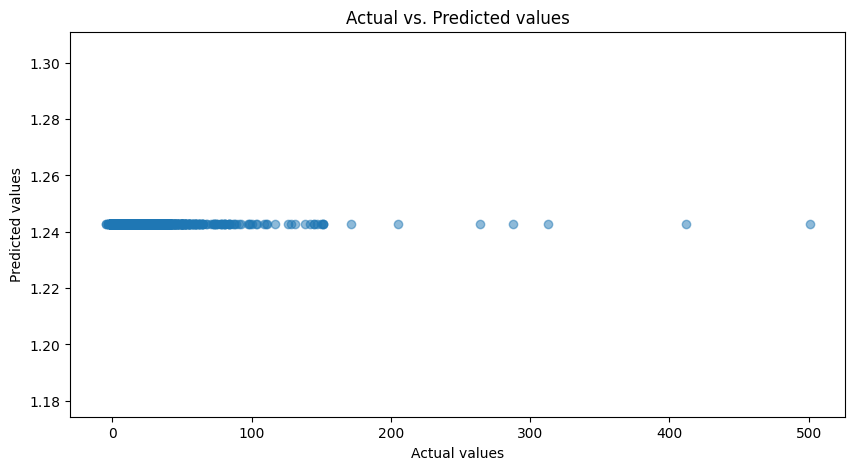

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Загрузка и предобработка данных
def load_data(filename):
    return pd.read_csv(filename)

def remove_outliers(df):
    # Идентификация и удаление строк с очевидными выбросами в количестве проданных товаров
    df = df[(df['item_cnt_day'] > 0) & (df['item_cnt_day'] < df['item_cnt_day'].quantile(0.99))]
    df = df[df['item_price'] > df['item_price'].quantile(0.01)]  #  исключаем распродажи по очень низкой цене
    return df

def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day'] = df['date'].dt.day
    df = remove_outliers(df)
    df = df.drop(columns=['date'])
    return df

# Разделение данных
def split_data(df):
    y = df['item_cnt_day']
    X = df.drop('item_cnt_day', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Нормализация данных
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Обучение модели Lasso
def train_lasso(X_train, y_train):
    model = Lasso(alpha=0.1)
    model.fit(X_train, y_train)
    return model

# Вычисление метрик
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'MSE: {mse}, MAE: {mae}, R^2: {r2}')
    return mse, mae, r2

# Отображение графиков
def plot_results(y_test, predictions):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title('Actual vs. Predicted values')
    plt.show()

if __name__ == "__main__":
    # Замените 'sales_train.csv' на путь к вашему файлу данных
    data = load_data('sales_train.csv')
    data_items = load_data('items.csv')
    data = pd.merge(data, data_items, on=['item_id'])
    data = data.drop(columns=['item_name'])
    processed_data = preprocess_data(data)
    data = data.drop(columns = ['date_block_num', 'date'])
    X_train, X_test, y_train, y_test = split_data(data)
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
    model = train_lasso(X_train_scaled, y_train)
    mse, mae, r2 = evaluate_model(model, X_test_scaled, y_test)
    predictions = model.predict(X_test_scaled)
    plot_results(y_test, predictions)
